In [1]:
filename_weather = "Ukraine.csv"
#filename_green = "ukr-ndvi-adm2-full.csv"
filename_green = "uk_green.csv"
#start = 2006
#end = 2021

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename, start_year=2003, end_year=2024):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()
        print(self.data.isna().sum())

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

            for i in range(self.residuals.shape[:,train_stop][1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model[:,train_stop].fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    # def fit(self, p,q, train_stop = None):
    #     self.fit_arma(order = (p,0,q), train_stop)
        # return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [3]:
wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
wm = WeatherModel(filename_weather)


wm.fit(order=(1, 0, 1))

STATION    0
DATE       0
DEWP       0
FRSHTT     0
MAX        0
MIN        0
MXSPD      0
PRCP       0
SLP        0
TEMP       0
VISIB      0
WDSP       0
dtype: int64
STATION    0
DATE       0
DEWP       0
FRSHTT     0
MAX        0
MIN        0
MXSPD      0
PRCP       0
SLP        0
TEMP       0
VISIB      0
WDSP       0
dtype: int64


Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


In [4]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (11315, 8)
Residual shape (8, 11316)
Num stacks 31
Num extras 1


(8, 11316)
(8, 7665)


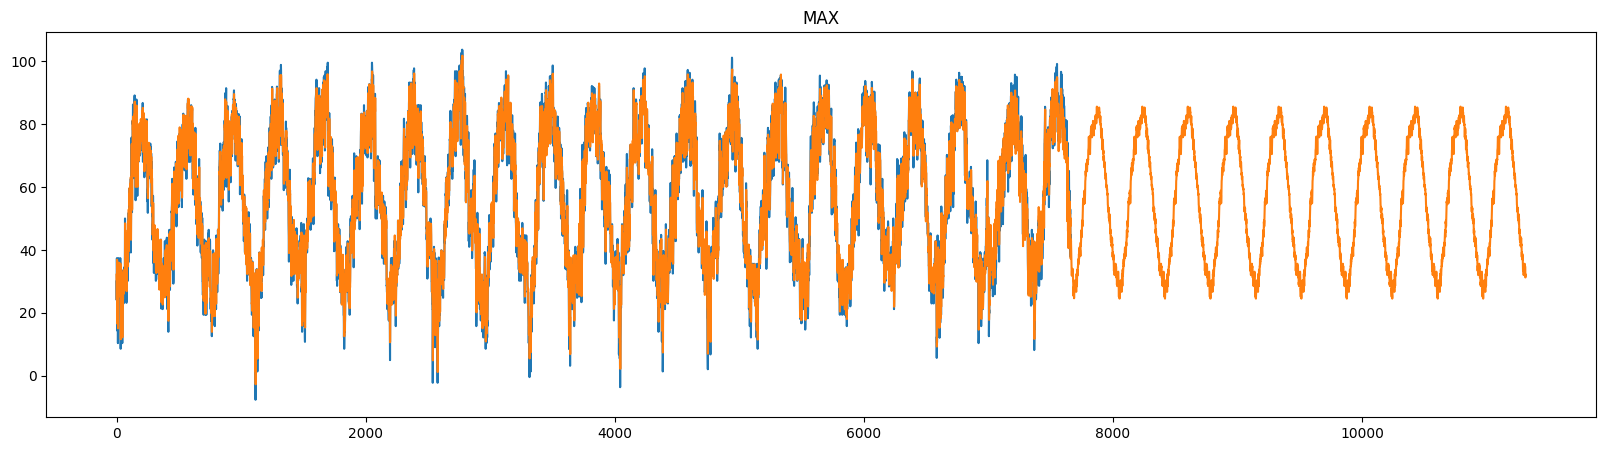

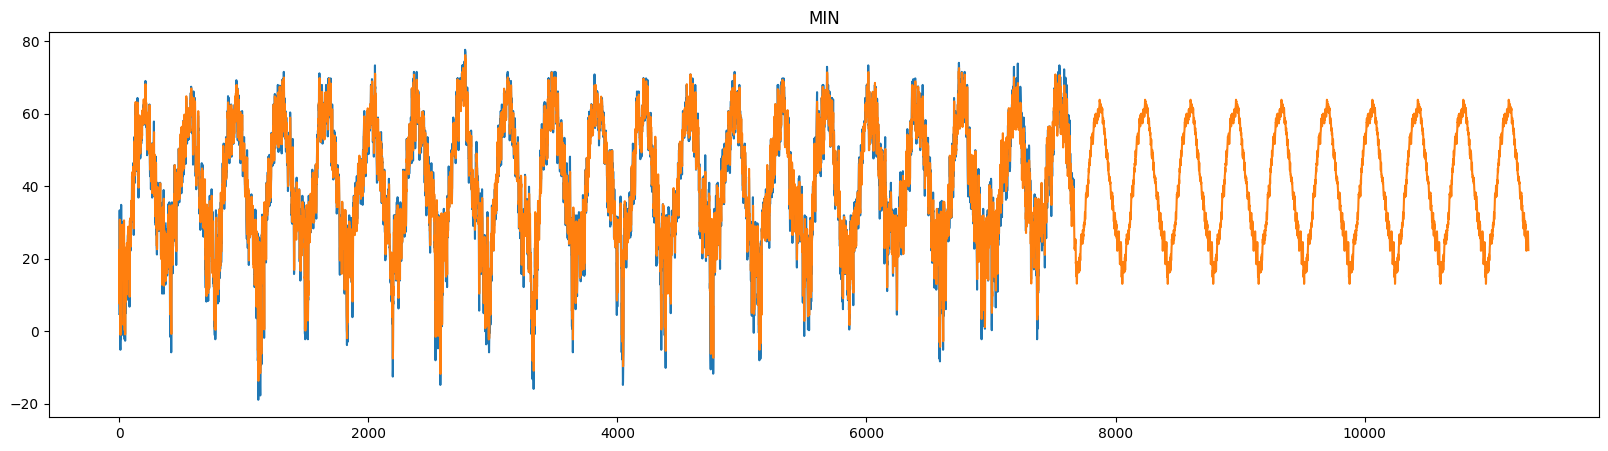

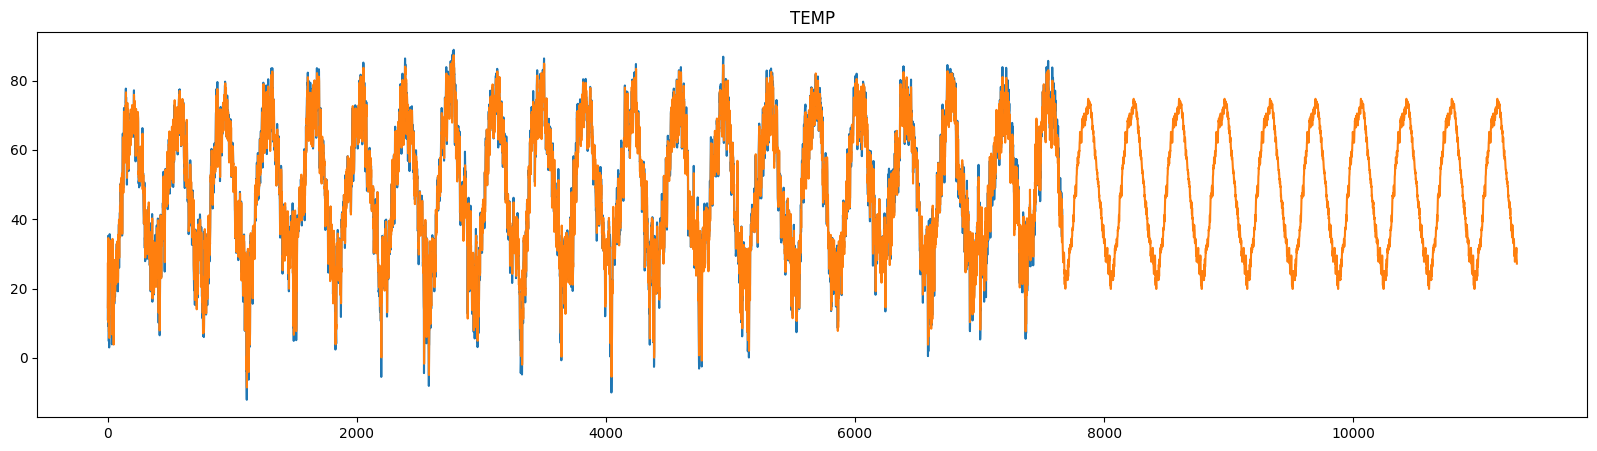

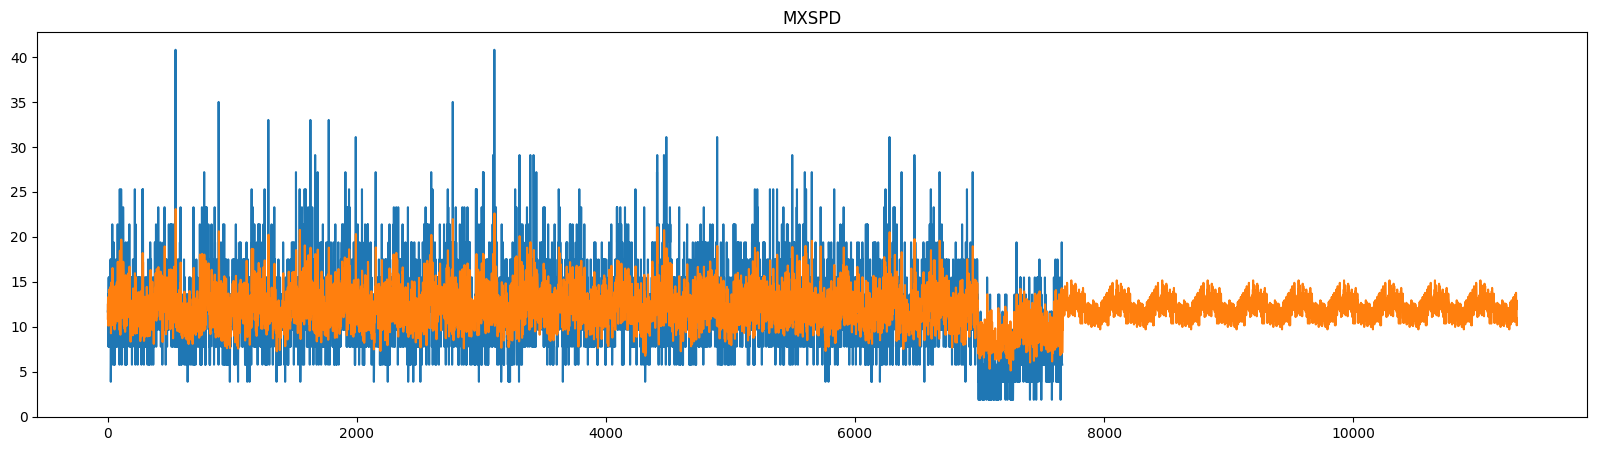

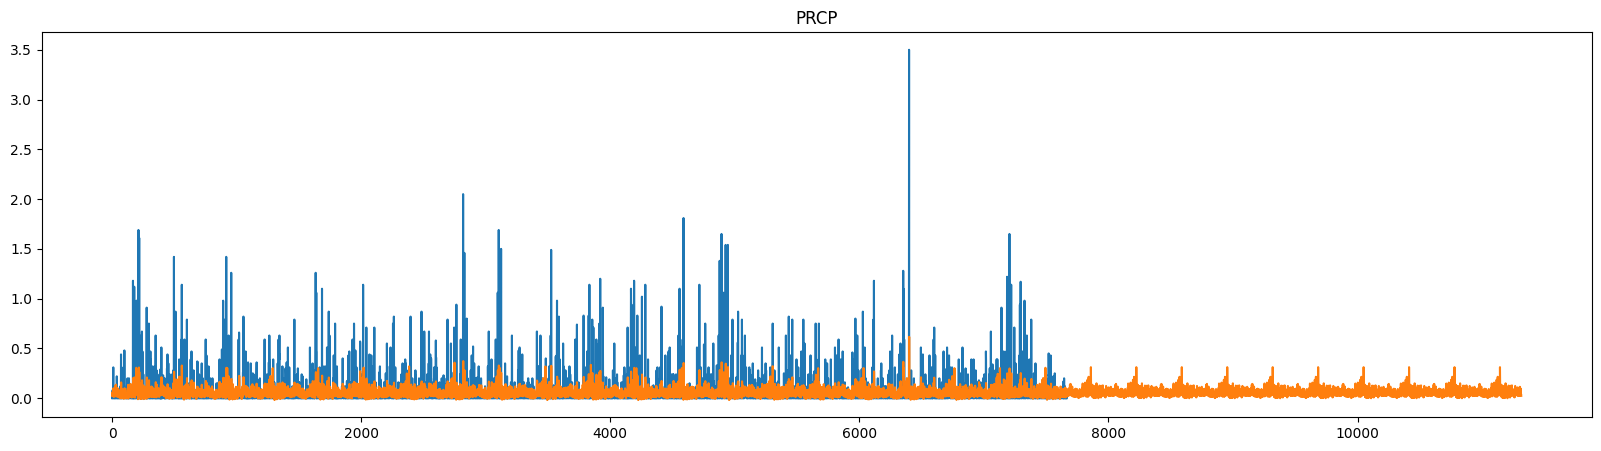

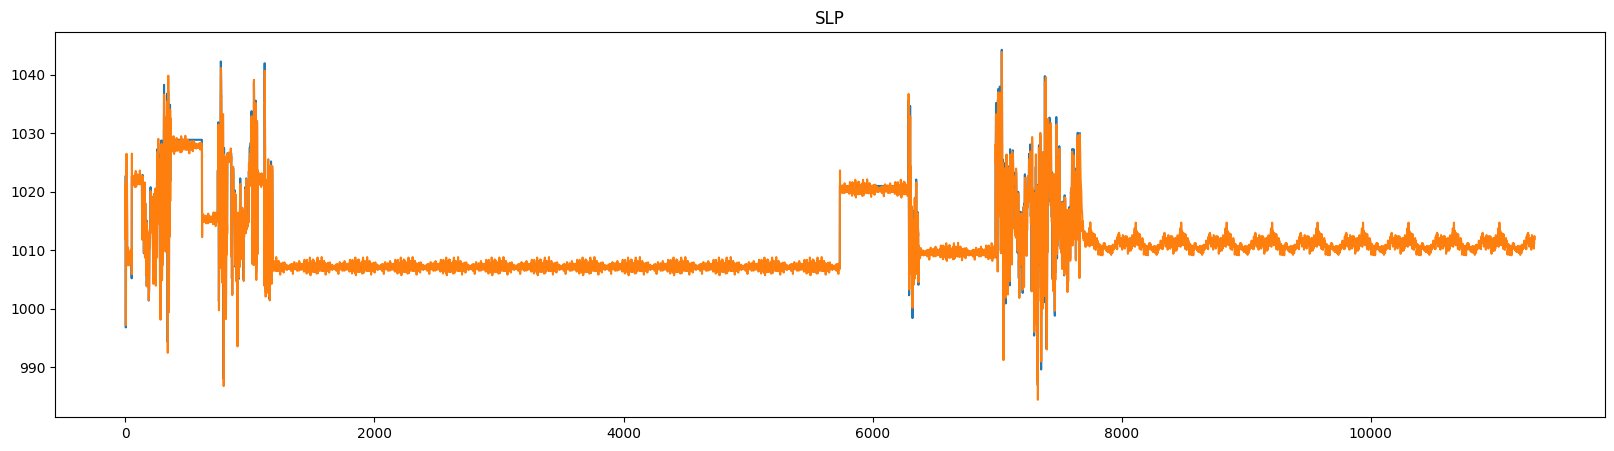

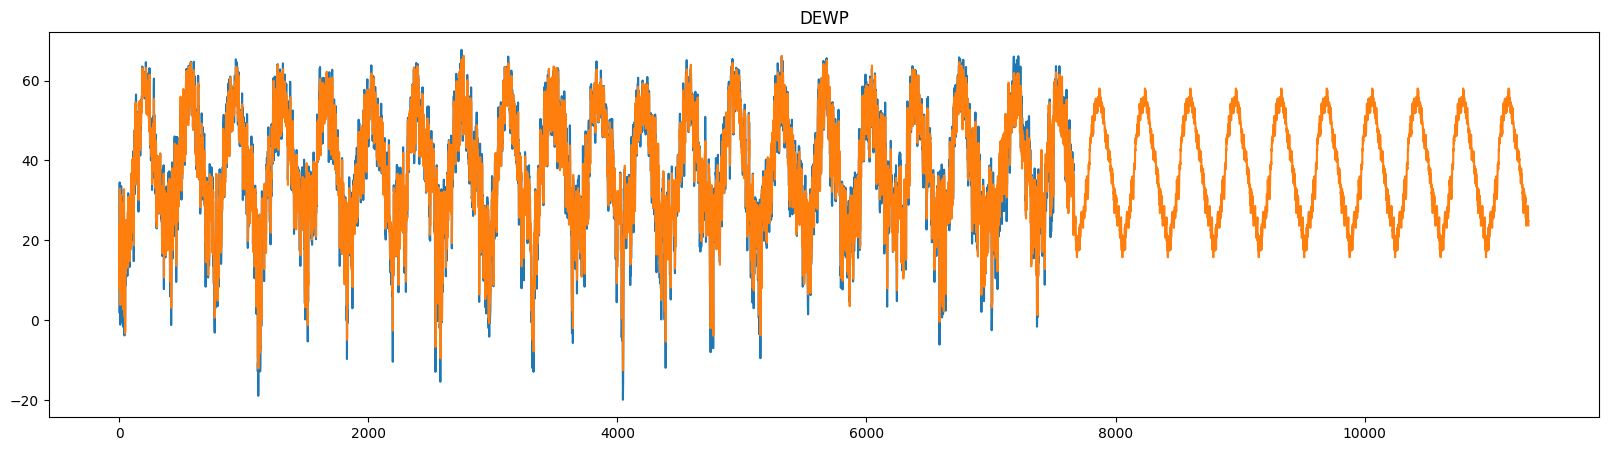

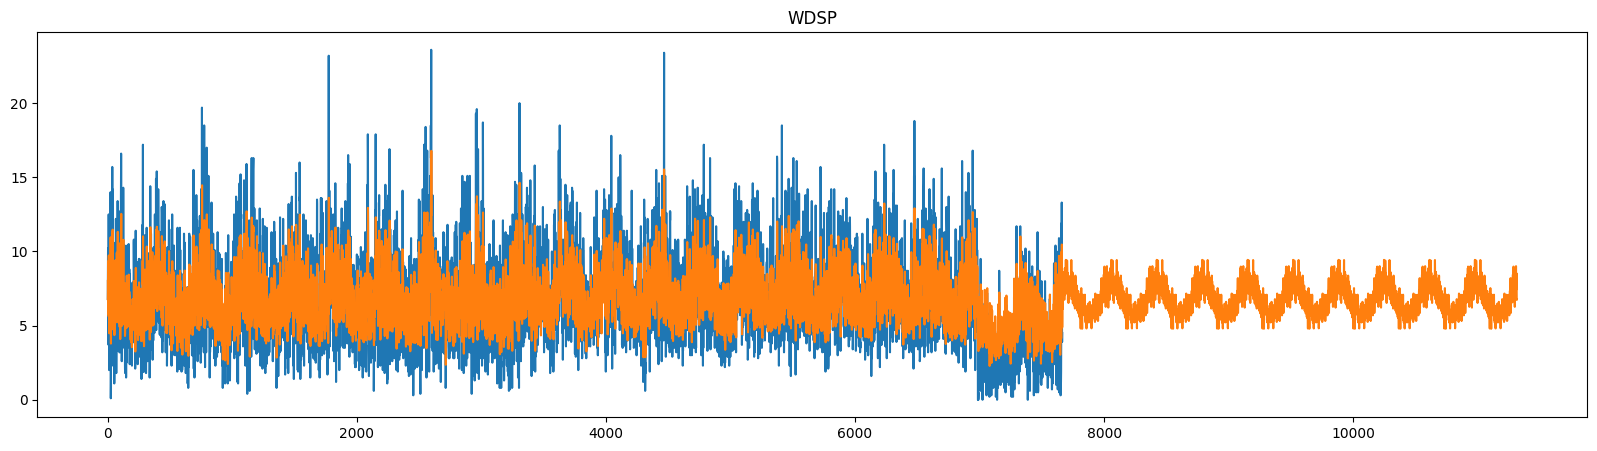

In [5]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


MAX      0
MIN      0
TEMP     0
MXSPD    0
PRCP     0
SLP      0
DEWP     0
WDSP     0
dtype: int64
(228,)
green (228,)
#date
2003-01-31    0.167667
2003-02-28    0.054767
2003-03-31    0.083767
2003-04-30    0.257833
2003-05-31    0.469167
Freq: M, Name: residuals, dtype: float64 #date
2021-08-31    0.566000
2021-09-30    0.519700
2021-10-31    0.446967
2021-11-30    0.330033
2021-12-31    0.190767
Freq: M, Name: residuals, dtype: float64
##################################
                  MAX        MIN       TEMP      MXSPD      PRCP          SLP  \
DATE                                                                            
2003-01-31  28.229032  17.183871  23.109677  11.793548  0.039032  1012.216129   
2003-02-28  22.660714   9.814286  17.232143  12.767857  0.015714  1012.546429   
2003-03-31  34.080645  21.258065  27.977419  12.974194  0.033548  1022.600000   
2003-04-30  51.356667  35.210000  43.443333  14.186667  0.034667  1022.600000   
2003-05-31  75.619355  53.983871  

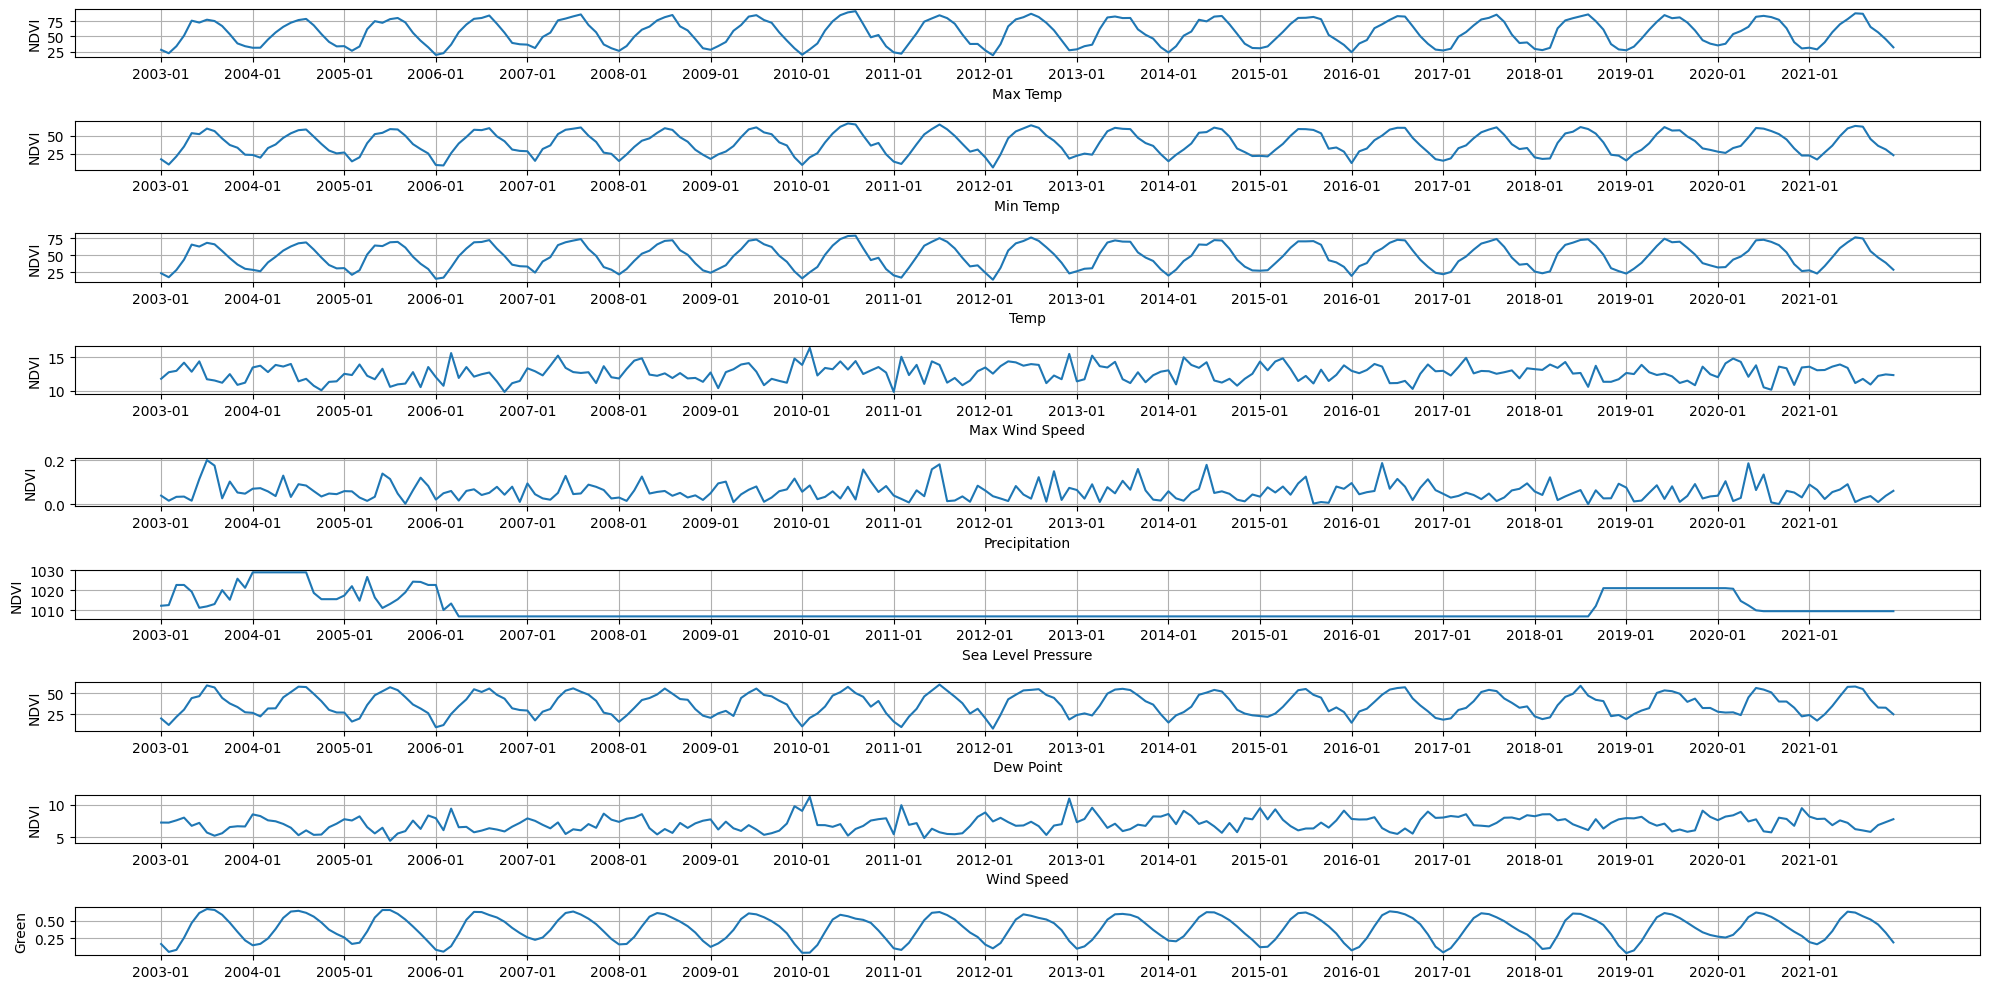

(228,)
(8, 228)


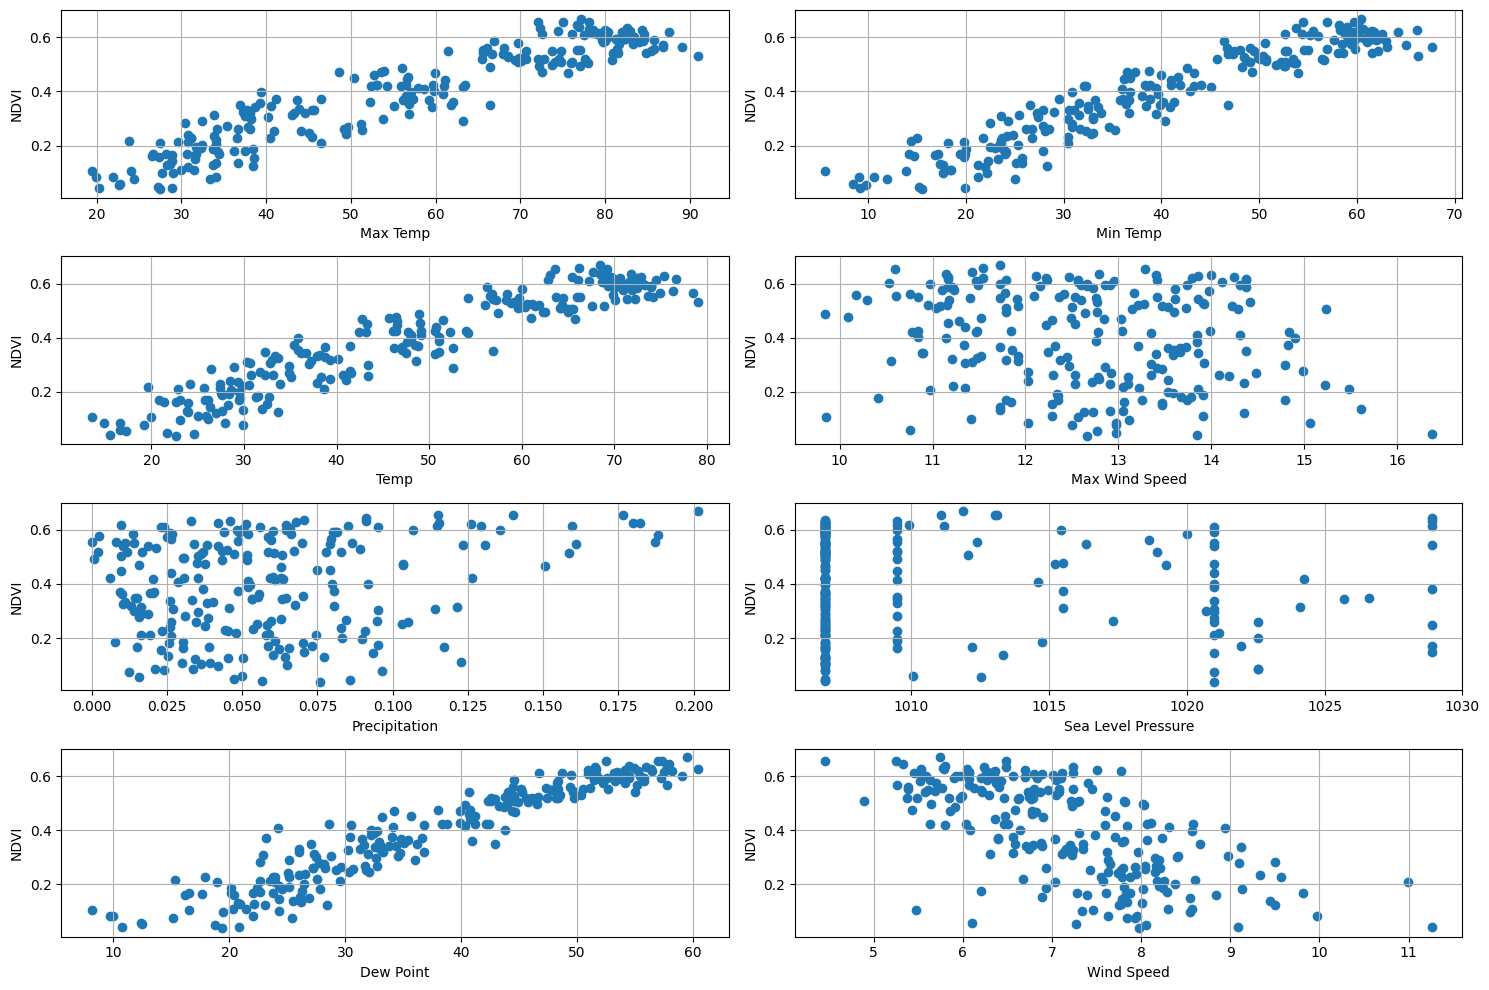

In [20]:
#Plotting the scatter of feature vs food prioce for triend
# unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
# weather = pd.read_csv('ilocos-sur-weather.csv')
# weather = weather[["DATE"] + feature_names]

# wdata = weather[feature_names].to_numpy()
# wdata -= wm.seasonal
# wdata = wdata.reshape(-1, wdata.shape[2]).T

# wdata = pd.DataFrame(wdata, columns=feature_names)
# weather = weather[["DATE"] + feature_names]


# weather = weather.set_index("DATE")
# weather = weather.resample('ME').max()

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
print(weather.isna().sum())
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year < 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('M').mean()

green = pd.read_csv(filename_green)#, skiprows=1)#, ignore_row=1)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year < 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('M').mean()
print(green.shape)

print("green", green.shape)

print(green.head(), green.tail())
print("##################################")
print(weather.head(), weather.tail())

y = green.values
weather = weather.to_numpy().T
print(weather.shape)
print(wm.seasonal.shape)

plt.figure(figsize=(20, 10))

feature_names2 = ["Max Temp", "Min Temp", "Temp", "Max Wind Speed", "Precipitation", "Sea Level Pressure", "Dew Point", "Wind Speed"]
for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
    plt.xlabel(feature_names2[i])
    plt.ylabel("NDVI")
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y)
    plt.xlabel(feature_names2[i])
    plt.ylabel("NDVI")
    plt.grid()
plt.tight_layout()
plt.savefig("Scatter_Ukraine.pdf", dpi=300, bbox_inches="tight")

plt.show()




In [8]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

class GreenModel():
    def __init__(self, lmda=0.1):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        self.lmda = lmda

    def fit(self, X, y):
        # Can use smoothing here
        basis_funcs = []
        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        bias0 = 0
        theta0 = np.concatenate([shift0, scale0, [bias0]])

        def f(theta):
            shift = theta[:X.shape[0]]
            scale = theta[X.shape[0]:-1]
            bias = theta[-1]

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                func = CubicSpline(xs, X[i])
                predictions += func(xs-shift[i]) * scale[i]
            predictions += bias

            return np.mean((predictions - y)**2) + self.lmda * np.sum(np.abs(theta))
        
        res = minimize(f, theta0, method="Nelder-Mead")
        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:-1]
        self.bias = self.theta[-1]
        self.basis_funcs = basis_funcs
        return res

    def predict(self, X):
        print(X.shape)
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            func = CubicSpline(xs, X[i])
            predictions += func(xs - self.shift[i]) * self.scale[i] 

        predictions += self.bias
        return predictions


In [9]:
gm = GreenModel(lmda=0)
features = weather[[0, 1, 2, 4, 6, 7]]
train_features = features[:, :150]
test_features = features[:, 150:]
gm.fit(features, y)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0038995859655425328
             x: [-7.176e-03  5.942e-03 ... -1.374e-02  1.497e-03]
           nit: 1529
          nfev: 2151
 final_simplex: (array([[-7.176e-03,  5.942e-03, ..., -1.374e-02,
                         1.497e-03],
                       [-7.176e-03,  5.942e-03, ..., -1.373e-02,
                         1.497e-03],
                       ...,
                       [-7.176e-03,  5.942e-03, ..., -1.374e-02,
                         1.497e-03],
                       [-7.176e-03,  5.942e-03, ..., -1.374e-02,
                         1.497e-03]]), array([ 3.900e-03,  3.900e-03, ...,  3.900e-03,  3.900e-03]))

(6, 78)


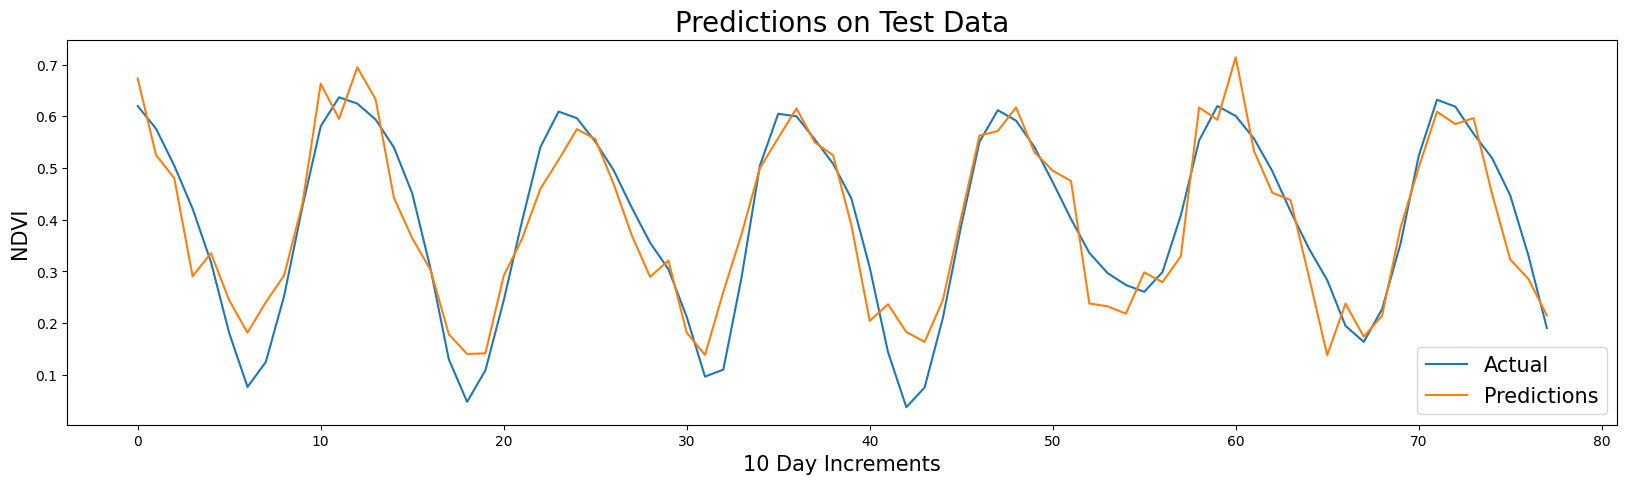

In [25]:
prediction = gm.predict(test_features)
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(prediction)), y[150:], label = "Actual")
plt.plot(np.arange(len(prediction)), prediction, label = "Predictions")
plt.title("Predictions on Test Data",fontsize=20)
plt.ylabel("NDVI", fontsize=15)
plt.xlabel("10 Day Increments", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("TestPredict_Ukraine.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [21]:

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y[150:], prediction))

0.0040750093367756994


In [11]:
plt.figure(figsize=(20, 5))
t = np.linspace(0, 200, 100)
plt.plot(t, gm.basis_funcs[0](t))
plt.show()

IndexError: list index out of range

<Figure size 2000x500 with 0 Axes>

In [ ]:
print(gm.shift)
print(gm.scale)

[-0.00717608  0.00594203  0.01060835 -0.01069424  0.00871355  0.00740172]
[ 1.47254390e-03 -1.05161046e-04  6.69171544e-03  1.23285934e+00
  4.03943169e-04 -1.37392793e-02]
